## Assignment №2: MOEX
---

#### Student:
---

<br><br>
**Goal of this assignment**: To do a little research project to examine trading patterns of the MOEX stocks.

In [3]:
# let's import all that we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import os


I'll start with reading data. I will unzip and convert it to .csv file

You can download dataset [over here](https://disk.yandex.ru/d/fWft1-QycHvqVw). And find data description [here](https://www.moex.com/ru/orders?orderlogs)

In [ ]:
# path to my folder
zip_folder = "C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\october2023typeB"
output_folder = "C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\Unziped_Data"

# make sure that output folder exists
os.makedirs(output_folder, exist_ok=True)

# work with all zip files in folder
for zip_filename in os.listdir(zip_folder):
    if zip_filename.endswith(".zip"):
        with ZipFile(os.path.join(zip_folder, zip_filename), 'r') as zip_ref:
            # Extract all files to the output folder
            zip_ref.extractall(output_folder)

#.txt to .csv
for file in os.listdir(output_folder):
    if file.endswith(".txt"):
        txt_path = os.path.join(output_folder, file)
        csv_path = txt_path.replace(".txt", ".csv")
        os.rename(txt_path, csv_path)


Now my goal is to combine all this .csv files in one dataframe. I will creat new column for each row named `date`, where I will save date of operation.<br>I will save only data with `AFKS, AFLT, AGRO, ALRS, CBOM, GAZP, GLTR, GMKN, MAGN, MGNT, SBER, SBERP, TRNFP, VKCO, VTBR` constituents cause only them I will describe in this assignment.<br> At the same time I will remove all data that include `NaN` in price column


In [31]:
output_folder = "C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\Unziped_Data"

save_to = "C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\combined_data\\combined_order_logs.csv"

# our stoks
seccodes = ["AFKS", "AFLT", "AGRO", "ALRS", "CBOM", "GAZP", "GLTR", "GMKN", 
                  "MAGN", "MGNT", "SBER", "SBERP", "TRNFP", "VKCO", "VTBR"]

# list of all .csv files in the folder
files = [f for f in os.listdir(output_folder) if f.endswith('.csv')]

for i, file in enumerate(files):
    
    date = file[-12:-4]
    
    # Read file in chunks
    chunks = pd.read_csv(os.path.join(output_folder, file), chunksize=100000)
    
    for chunk in chunks:
        # I'll filter based on SECCODES
        filtered_chunk = chunk[chunk['SECCODE'].isin(seccodes)]
        
        # Drop rows with NaN values in any column
        cleaned_chunk = filtered_chunk.dropna(subset=['PRICE'])
        
        
        cleaned_chunk['date'] = date
        
        # Append or create the combined file
        mode = 'w' if i == 0 and chunk.index[0] == 0 else 'a'  # write for the 1st chunk, append for others
        header = i == 0 and chunk.index[0] == 0  # write header only for the 1st chunk
        cleaned_chunk.to_csv(save_to, mode=mode, header=header, index=False)

print(f"\n\n\nFiltered and cleaned data from all files combined and saved to: combined_order_logs.csv")

# Load the entire combined file into a DataFrame
combined_data = pd.read_csv(save_to, index_col=False)
print("Combined data loaded into DataFrame successfully.")




Filtered and cleaned data from all files combined and saved to: combined_order_logs.csv
Combined data loaded into DataFrame successfully.


In [4]:
combined_data = pd.read_csv("C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\combined_data\\combined_order_logs.csv", index_col=False)
print(f"Size of my dataframe: {combined_data.shape}")

combined_data.head(10)

Size of my dataframe: (68322575, 7)


,SECCODE,BUYSELL,TIME,TRADENO,PRICE,VOLUME,date
0,GAZP,B,100000005313,8.521259e+09,167.83,10,20231002
1,GAZP,B,100000005313,NaN,179.42,10,20231002
2,GAZP,S,100000005313,NaN,151.00,2570,20231002
3,GAZP,S,100000005313,8.521259e+09,167.83,10,20231002
4,GAZP,B,100000005313,8.521259e+09,167.83,10,20231002
5,GAZP,S,100000005313,8.521259e+09,167.83,10,20231002
6,GAZP,B,100000005313,8.521259e+09,167.83,50,20231002
7,GAZP,S,100000005313,8.521259e+09,167.83,50,20231002
8,GAZP,B,100000005313,8.521259e+09,167.83,10,20231002
9,GAZP,S,100000005313,8.521259e+09,167.83,10,20231002


In [3]:
a = str(100000005313)
print(a[:4])

1000


In the end I can say that we've stored data only with constituents that we need and without any Nan values in price column and save it to `combined_order_logs.csv`. <br> Now we have: 68322575 numbers of rows in our dataframe. Lets see how we can clean our data more<br>We can remove all rows were TRADENO - Nan cause it's number of сделки

In [5]:
filtered_data = combined_data.dropna(subset=['TRADENO'])

print(f"We've done. Size of new dataframe: {filtered_data.shape}\n\nWe've removed {100 - ((filtered_data.shape[0] / combined_data.shape[0]) * 100):.3f}% of data for TRADENO criteria")

We've done. Size of new dataframe: (18317572, 7)

We've removed 73.190% of data for TRADENO criteria


In [6]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18317572 entries, 0 to 68322574
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   SECCODE  object 
 1   BUYSELL  object 
 2   TIME     int64  
 3   TRADENO  float64
 4   PRICE    float64
 5   VOLUME   int64  
 6   date     int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 1.1+ GB


As we've learned from pdf. We have Time in the next format: HHMMSSZZZXXX 

In [ ]:
#create hour and minute columns from the TIME column
filtered_data['hour'] = filtered_data['TIME'].astype(str).str[:2].astype(int) 
filtered_data['minute'] = filtered_data['TIME'].astype(str).str[2:4].astype(int)

# filter 9:50 - 18:50  
filtered_data_1 = filtered_data[
    ((filtered_data['hour'] == 9) & (filtered_data['minute'] >= 50)) |
    ((filtered_data['hour'] > 9) & (filtered_data['hour'] < 18)) |   
    ((filtered_data['hour'] == 18) & (filtered_data['minute'] <= 50)) 
]

# drop 'hour' and 'minute' columns
filtered_data_1 = filtered_data_1.drop(columns=['hour', 'minute'])

print(f"We've done. Size of new dataframe: {filtered_data_1.shape}\n\nWe've removed {100 - ((filtered_data_1.shape[0] / filtered_data.shape[0]) * 100):.3f}% of data for time criteria")


C:\Users\user\AppData\Local\Temp\ipykernel_4476\1625286355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour'] = filtered_data['TIME'].astype(str).str[:2].astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_4476\1625286355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['minute'] = filtered_data['TIME'].astype(str).str[2:4].astype(int)


We've done. Size of new dataframe: (18255996, 7)

We've removed 0.336% of data for time criteria


Let's
 remove all duplicates 


In [13]:
filtered_data_1 = filtered_data_1.drop_duplicates()

print(f"We've done. Size of new dataframe: {filtered_data_1.shape}")


We've done. Size of new dataframe: (18255996, 7)


As we can see, we don't have any duplicates<br>

In [22]:
column_names = ["SECCODE","BUYSELL","TIME","VOLUME","date"]

for name in column_names:
    nan_counts = filtered_data_1[name].isna().sum()
    print(f'{name}: {nan_counts}')

SECCODE: 0
BUYSELL: 0
TIME: 0
VOLUME: 0
date: 0


In [23]:
# let me cheack how many unique values do we have
# should be SECCODE = 15, BUYSELL = 2, date = 22
object_features = ['SECCODE', 'BUYSELL', 'date']

for column in object_features:
    print(f"{column}: {filtered_data_1[column].nunique()} unique values")

SECCODE: 15 unique values
BUYSELL: 2 unique values
date: 22 unique values


In [36]:
# remove rows where PRICE has = 0
preprocessed_df = filtered_data_1[filtered_data_1['PRICE'] != 0]
print(preprocessed_df.shape)

# Display the shape of the resulting DataFrame
print(f"We've done. Size of new dataframe: {preprocessed_df.shape}")

(18255996, 7)
We've done. Size of new dataframe: (18255996, 7)


And finally we can remove duplicate trades where the same transaction is recorded twice: once as `Buy` and once as `Sell`

In [37]:
processed_df = preprocessed_df.drop_duplicates(subset=['SECCODE', 'TIME', 'TRADENO', 'PRICE', 'VOLUME', 'date'])

print(f"We've done. Size of new dataframe: {processed_df.shape}\n\nWe've removed {(((preprocessed_df.shape[0] - processed_df.shape[0])/ preprocessed_df.shape[0]) * 100):.3f}% of data for `transaction duplicates` criteria")


# Save the cleaned DataFrame to a new CSV file if needed
processed_df.to_csv("C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\Processed_data\\processed_data.csv", index=False)

We've done. Size of new dataframe: (9127998, 7)

We've removed 50.000% of data for `transaction duplicates` criteria


Now we've done with preprocessing of data. 
### Next step is to:
1. Calculate average daily ruble volume
2. Daily realized volatility (the square root of the sum of all squared log-differences of prices during the day)
3. Number of transactions
4. Median ruble size of transactions
---

In [38]:
data = pd.read_csv("C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\Processed_data\\processed_data.csv")

# it's our seccode
seccodes = data['SECCODE'].unique()

# dictionary to store results
results = {}

# Loop through each SECCODE
for code in seccodes:
    # filter data
    stock_data = data[data['SECCODE'] == code]
    
    # group by date for daily calculations
    grouped = stock_data.groupby('date')
    
    # average daily ruble volume
    buy_avg_daily_volume = grouped.apply(lambda x: (x['PRICE'] * x['VOLUME']).sum()).mean()
    
    # daily realized volatility
    def realized_volatility(group):
        log_returns = np.log(group['PRICE']).diff()
        return np.sqrt((log_returns ** 2).sum())
    
    buy_volatility = grouped.apply(realized_volatility).mean()
    
    # number of transactions
    buy_transactions = grouped.size().mean()
    
    # median ruble size of transactions
    buy_median_ruble_size = grouped.apply(lambda x: (x['PRICE'] * x['VOLUME']).median()).median()
    
    # Store results for this SECCODE
    results[code] = {
        "Average Daily Volume": buy_avg_daily_volume,
        "Daily Volatility": buy_volatility,
        "Average Transactions": buy_transactions,
        "Median Ruble Size": buy_median_ruble_size,
    }

results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df)

# Save results to a CSV file
results_df.to_csv("4th_task.csv")


C:\Users\user\AppData\Local\Temp\ipykernel_4476\4143237582.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  buy_avg_daily_volume = grouped.apply(lambda x: (x['PRICE'] * x['VOLUME']).sum()).mean()
C:\Users\user\AppData\Local\Temp\ipykernel_4476\4143237582.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  buy_volatility = grouped.apply(realized_volatility).mean()
C:\Users\user\AppData\Local\Temp\ipyker

       Average Daily Volume  Daily Volatility  Average Transactions  \
GAZP           3.527903e+09          0.015113          57816.727273   
AGRO           1.328405e+09          0.042442          31938.409091   
ALRS           1.155141e+09          0.027572          35250.636364   
AFLT           2.762012e+08          0.025703          10220.863636   
SBER           8.199113e+09          0.012620          87203.000000   
AFKS           3.307517e+08          0.016860           9987.500000   
GMKN           1.511901e+09          0.016184          16858.772727   
MGNT           1.749113e+09          0.019400          22706.681818   
MAGN           5.997891e+08          0.021033          22077.863636   
SBERP          6.654762e+08          0.013609          12259.090909   
VTBR           2.038567e+09          0.031034          56356.000000   
TRNFP          1.685541e+09          0.016451           5432.636364   
GLTR           1.252516e+08          0.025501           9372.409091   
CBOM  

C:\Users\user\AppData\Local\Temp\ipykernel_4476\4143237582.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  buy_avg_daily_volume = grouped.apply(lambda x: (x['PRICE'] * x['VOLUME']).sum()).mean()
C:\Users\user\AppData\Local\Temp\ipykernel_4476\4143237582.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  buy_volatility = grouped.apply(realized_volatility).mean()
C:\Users\user\AppData\Local\Temp\ipyker

We've done with this task. Result u can see in `4th_task.csv`. Also u can find official results [over here](https://www.moex.com/ru/marketdata/#/mode=groups&group=4&collection=160&boardgroup=57&data_type=history&date=2023-10-03&category=main)


Answer the following questions:
1. Which stock was the most/least volatile during the period under investigation?
2. Which stock had the largest/lowest share volume? ruble volume?
3. Which stock had the largest/lowest number of transactions?
4. Which stock had the largest/lowest number of quotes changes?
5. On which day of the week stocks had the largest/lowest volume in the sample?
6. Which stock had the highest/lowest ruble bid-ask spread? percentage bid-ask
spread?

In [4]:
metrics = pd.read_csv("4th_task.csv", index_col=0)
data = pd.read_csv("C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\Processed_data\\processed_data.csv") 

# Add weekday column for weekday calculations
data['weekday'] = pd.to_datetime(data['date'], format='%Y%m%d').dt.day_name()

most_volatile = metrics['Daily Volatility'].idxmax()
least_volatile = metrics['Daily Volatility'].idxmin()

largest_share_volume = metrics['Average Daily Volume'].idxmax()
lowest_share_volume = metrics['Average Daily Volume'].idxmin()

# Calculate ruble volume
data['ruble_volume'] = data['PRICE'] * data['VOLUME']
ruble_volume = data.groupby('SECCODE')['ruble_volume'].sum()
largest_ruble_volume = ruble_volume.idxmax()
lowest_ruble_volume = ruble_volume.idxmin()


largest_transactions = metrics['Average Transactions'].idxmax()
lowest_transactions = metrics['Average Transactions'].idxmin()


quote_changes = data.groupby('SECCODE')['PRICE'].nunique()
largest_quote_changes = quote_changes.idxmax()
lowest_quote_changes = quote_changes.idxmin()


weekday_ruble_volume = data.groupby('weekday')['ruble_volume'].sum()
largest_volume_day = weekday_ruble_volume.idxmax()
lowest_volume_day = weekday_ruble_volume.idxmin()

 
data['hour'] = data['TIME'].astype(str).str[:2]
data['minute'] = data['TIME'].astype(str).str[2:4]

# combine h and min for grouping
data['minute'] = data['hour'] + ':' + data['minute']

# group data by SECCODE and min
minute_grouped = data.groupby(['SECCODE', 'minute'])

# approximate ASK and BID
# here i took min and max but it's better to take a mean (cause if min max мы получаем отрицательный сприд постоянно)
ask_prices = minute_grouped['PRICE'].max()
bid_prices = minute_grouped['PRICE'].min()

# merge ASK and BID back into the original DataFrame
data = data.merge(ask_prices.rename('ASK'), on=['SECCODE', 'minute'])
data = data.merge(bid_prices.rename('BID'), on=['SECCODE', 'minute'])

# Calculate ruble and percentage spreads
data['ruble_spread'] = data['ASK'] - data['BID']
data['percentage_spread'] = (data['ASK'] - data['BID']) / ((data['ASK'] + data['BID']) / 2) * 100

# Calculate average spreads for each SECCODE
spread_grouped = data.groupby('SECCODE')
highest_ruble_spread = spread_grouped['ruble_spread'].mean().idxmax()
lowest_ruble_spread = spread_grouped['ruble_spread'].mean().idxmin()
highest_percentage_spread = spread_grouped['percentage_spread'].mean().idxmax()
lowest_percentage_spread = spread_grouped['percentage_spread'].mean().idxmin()

print(f"1. Most volatile stock: {most_volatile}, Least volatile stock: {least_volatile}")
print(f"2. Largest share volume: {largest_share_volume}, Lowest share volume: {lowest_share_volume}")
print(f"   Largest ruble volume: {largest_ruble_volume}, Lowest ruble volume: {lowest_ruble_volume}")
print(f"3. Largest transactions: {largest_transactions}, Lowest transactions: {lowest_transactions}")
print(f"4. Largest quote changes: {largest_quote_changes}, Lowest quote changes: {lowest_quote_changes}")
print(f"5. Day with largest volume: {largest_volume_day}, Day with lowest volume: {lowest_volume_day}")
print(f"6. Highest ruble spread: {highest_ruble_spread}, Lowest ruble spread: {lowest_ruble_spread}")
print(f"   Highest percentage spread: {highest_percentage_spread}, Lowest percentage spread: {lowest_percentage_spread}")


1. Most volatile stock: VKCO, Least volatile stock: SBER
2. Largest share volume: SBER, Lowest share volume: GLTR
   Largest ruble volume: SBER, Lowest ruble volume: GLTR
3. Largest transactions: SBER, Lowest transactions: TRNFP
4. Largest quote changes: AGRO, Lowest quote changes: TRNFP
5. Day with largest volume: Monday, Day with lowest volume: Thursday
6. Highest ruble spread: TRNFP, Lowest ruble spread: VTBR
   Highest percentage spread: AGRO, Lowest percentage spread: MAGN


## Next task:<br>  
Examine empirically what is the relationship between the number of trades and the
number of quotes changes? For example, plot the log of the number of trades against
the log of the number of quotes changes calculated for each stock and each trading day.


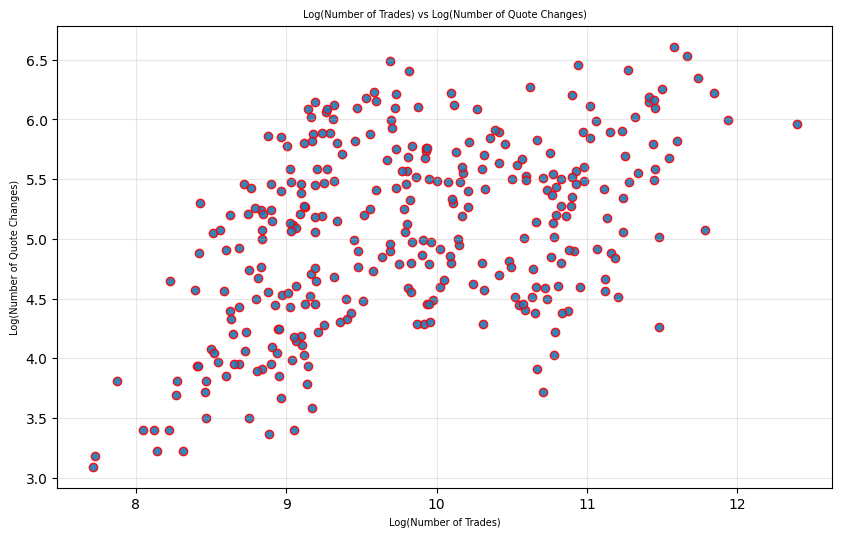

Correlation between log(Number of Trades) and log(Number of Quote Changes): 0.473


In [12]:
path = "C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\Processed_data\\processed_data.csv"
data = pd.read_csv(path)

# Group by SECCODE and date to calculate metrics
grouped = data.groupby(['SECCODE', 'date'])

# Calculate the number of trades and number of quote changes for each stock and day
metrics = grouped.agg(
    num_trades=('TRADENO', 'count'),# total rows per group
    num_quote_changes=('PRICE', 'nunique')  # unique price changes
).reset_index()

# Add log-transformed columns
metrics['log_num_trades'] = np.log(metrics['num_trades'])
metrics['log_num_quote_changes'] = np.log(metrics['num_quote_changes'])

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(metrics['log_num_trades'], metrics['log_num_quote_changes'], alpha=0.9, edgecolor='r')
plt.title("Log(Number of Trades) vs Log(Number of Quote Changes)", fontsize=7)
plt.xlabel("Log(Number of Trades)", fontsize=7)
plt.ylabel("Log(Number of Quote Changes)", fontsize=7)
plt.grid(alpha=0.3)
plt.savefig('C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\Plots\\result_1.png')
plt.show()


# calculate correlation between log metrics
correlation = metrics[['log_num_trades', 'log_num_quote_changes']].corr().iloc[0, 1]
print(f"Correlation between log(Number of Trades) and log(Number of Quote Changes): {correlation:.3f}")


### Next task 
Trading volume often exhibits specific intraday patterns. Examine intraday patterns in
volume by calculating the average ruble volume executed during each 30-min period
between 9:50 and 18:50; Stocks differ a lot by volume. To
aggregate data across 15 stocks into one chart, you may plot, for example, the typical
fraction of daily volume executed during each thirty-minute interval (and then
averaged across all stocks).


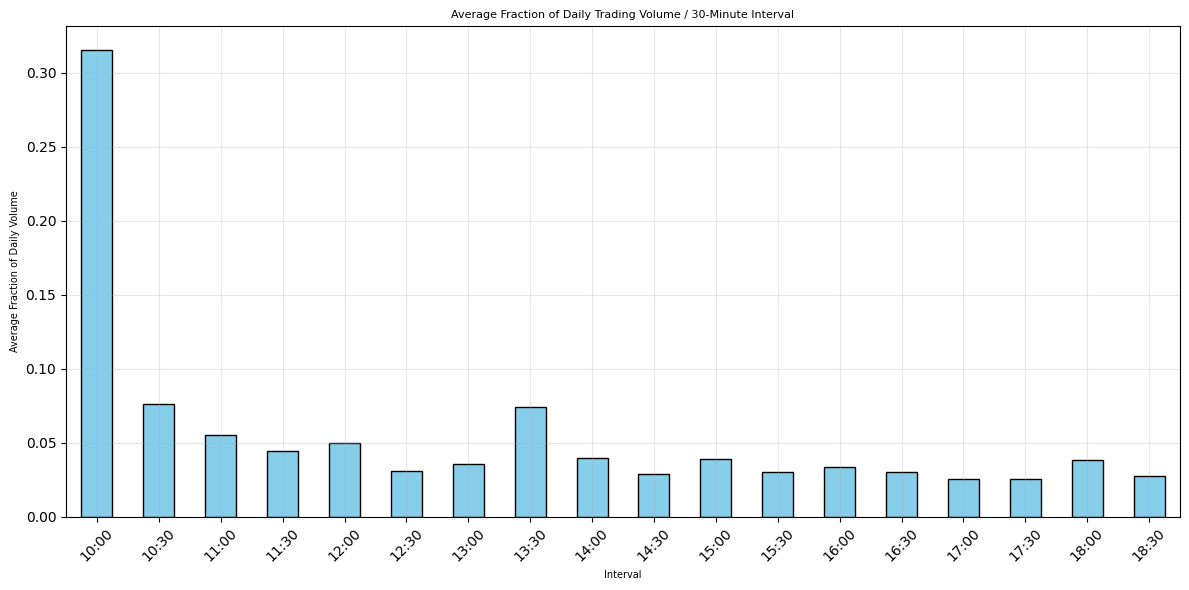

In [15]:
path = "C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\Processed_data\\processed_data.csv"
data = pd.read_csv(path)

data['hour'] = data['TIME'].astype(str).str[:2]  # First 2 characters for hour
data['minute'] = data['TIME'].astype(str).str[2:4]  # Next 2 characters for minute

# Combine hour and minute for 30-minute intervals
data['interval'] = data['hour'] + ':' + data['minute']

# Define 30-minute intervals from 9:50 to 18:50
intervals = ['09:50', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30', 
             '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', 
             '16:00', '16:30', '17:00', '17:30', '18:00', '18:30', '18:50']

# Filter the data between 9:50 and 18:50 (excluding later intervals)
data = data[data['interval'].isin(intervals)]

# Create ruble volume column
data['ruble_volume'] = data['PRICE'] * data['VOLUME']

# Group by SECCODE and interval to calculate the total ruble volume for each stock per 30-min interval
interval_grouped = data.groupby(['SECCODE', 'interval']).agg({'ruble_volume': 'sum'}).reset_index()

# Calculate the total ruble volume for each stock across all intervals for normalization
total_ruble_volume = data.groupby('SECCODE')['ruble_volume'].sum().reset_index()
total_ruble_volume = total_ruble_volume.rename(columns={'ruble_volume': 'total_ruble_volume'})

# Merge total volume with the interval data
interval_grouped = pd.merge(interval_grouped, total_ruble_volume, on='SECCODE')

# Calculate the fraction of daily volume for each stock and interval
interval_grouped['fraction_of_daily_volume'] = interval_grouped['ruble_volume'] / interval_grouped['total_ruble_volume']

# Handle shorter intervals (9:50–10:00 and 18:50–19:00) by normalizing them (multiplying by 3 to adjust for 10-minute duration)
interval_grouped.loc[interval_grouped['interval'] == '09:50', 'fraction_of_daily_volume'] *= 3
interval_grouped.loc[interval_grouped['interval'] == '18:50', 'fraction_of_daily_volume'] *= 3

# Calculate the average fraction of daily volume across all stocks for each 30-minute interval
average_fraction = interval_grouped.groupby('interval')['fraction_of_daily_volume'].mean()

# Plot the average fraction of daily volume for each interval
plt.figure(figsize=(12, 6))
average_fraction.plot(kind='bar', color='skyblue', edgecolor='k')
plt.title("Average Fraction of Daily Trading Volume / 30-Minute Interval", fontsize=8)
plt.xlabel("Interval", fontsize=7)
plt.ylabel("Average Fraction of Daily Volume", fontsize=7)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()

# Save the plot to a specific folder
plt.savefig("C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\Plots\\result_2.png")

# Show the plot
plt.show()



### Examine whether bid-ask spreads for the set of blue-chip stocks are consistent with invariance predictions.
1. Plot ln(Spread/P) vs ln(1/L). Check whether the slope is similar to 1 as predicted by
invariance.<br>
Color observations for different stocks in different colors (15 colors in total).
3. Plot ln(Spread) vs ln(P/L). Color observations for different stocks in different colors
(15 colors in total).

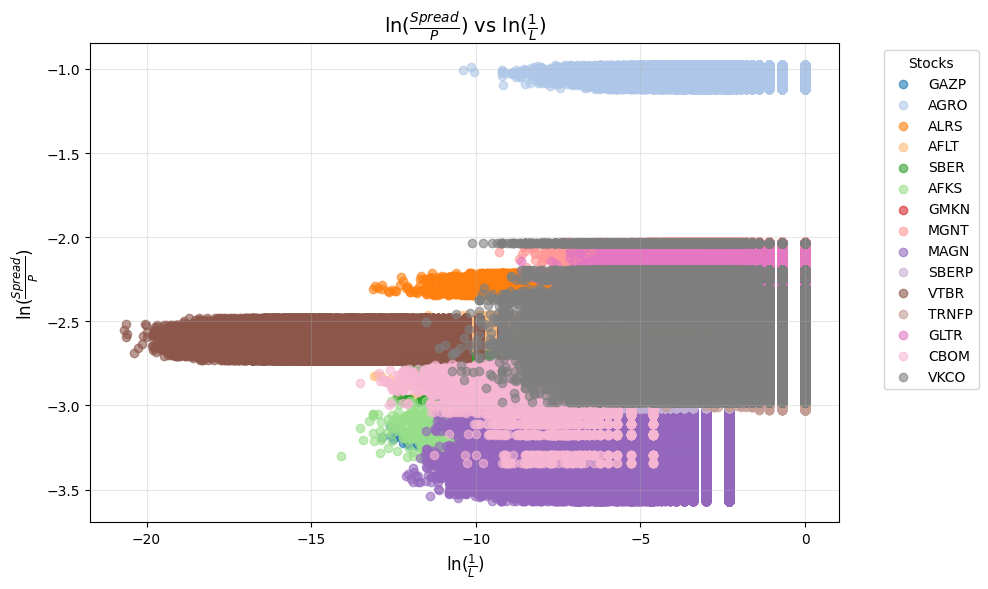

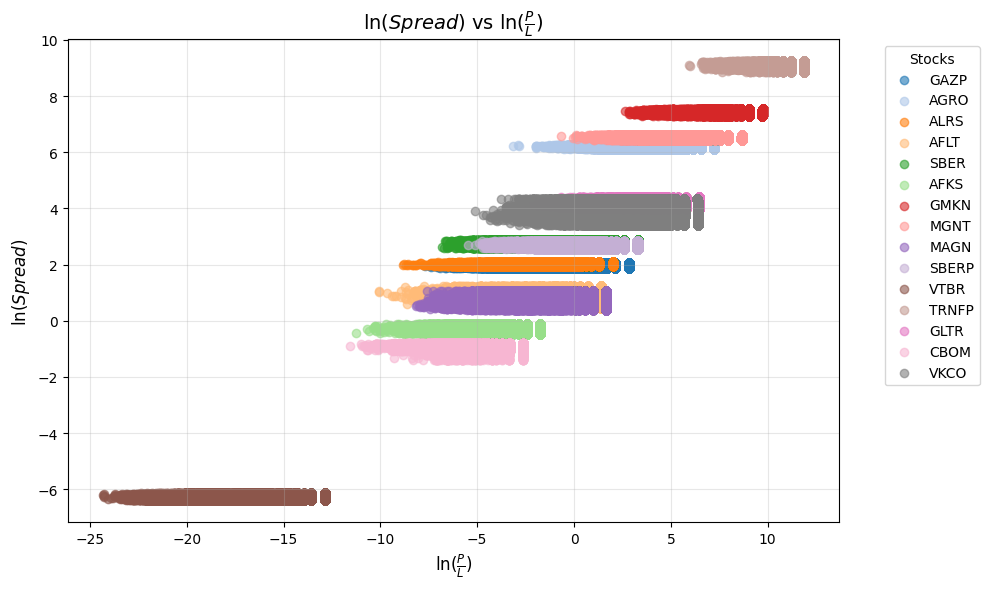

In [16]:
data = pd.read_csv("C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\Processed_data\\processed_data.csv")

# Extract hour and minute from TIME (HHMMSSZZZXXX format)
data['hour'] = data['TIME'].astype(str).str[:2]
data['minute'] = data['TIME'].astype(str).str[2:4]
data['minute_interval'] = data['hour'] + ':' + data['minute']

# Group by SECCODE and minute interval to approximate ASK and BID
minute_grouped = data.groupby(['SECCODE', 'minute_interval'])

# Calculate ASK (max price) and BID (min price)
ask_prices = minute_grouped['PRICE'].max().rename('ASK')
bid_prices = minute_grouped['PRICE'].min().rename('BID')

# Merge ASK and BID back into the main DataFrame
data = data.merge(ask_prices, on=['SECCODE', 'minute_interval'])
data = data.merge(bid_prices, on=['SECCODE', 'minute_interval'])

# Filter out invalid rows (e.g., spreads ≤ 0 or missing volume)
data = data[(data['ASK'] > data['BID']) & (data['VOLUME'] > 0)]

# Calculate mid-price and spread
data['mid_price'] = (data['ASK'] + data['BID']) / 2
data['spread'] = data['ASK'] - data['BID']

# Calculate ln(Spread/P), ln(1/L), ln(Spread), and ln(P/L)
data['ln_spread_over_price'] = np.log(data['spread'] / data['mid_price'])
data['ln_inverse_volume'] = np.log(1 / data['VOLUME'])
data['ln_spread'] = np.log(data['spread'])
data['ln_price_over_volume'] = np.log(data['mid_price'] / data['VOLUME'])

# Assign unique colors to each stock
unique_stocks = data['SECCODE'].unique()
stock_colors = {stock: color for stock, color in zip(unique_stocks, plt.cm.tab20.colors)}

# ---- a) Plot ln(Spread/P) vs ln(1/L) ----
plt.figure(figsize=(12, 6))
for stock in unique_stocks:
    subset = data[data['SECCODE'] == stock]
    plt.scatter(subset['ln_inverse_volume'], subset['ln_spread_over_price'], 
                label=stock, color=stock_colors[stock], alpha=0.6)
plt.title(r"$\ln(\frac{Spread}{P})$ vs $\ln(\frac{1}{L})$", fontsize=14)
plt.xlabel(r"$\ln(\frac{1}{L})$", fontsize=12)
plt.ylabel(r"$\ln(\frac{Spread}{P})$", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("ln_spread_over_price_vs_ln_inverse_volume.png", dpi=300)
plt.show()

# ---- b) Plot ln(Spread) vs ln(P/L) ----
plt.figure(figsize=(12, 6))
for stock in unique_stocks:
    subset = data[data['SECCODE'] == stock]
    plt.scatter(subset['ln_price_over_volume'], subset['ln_spread'], 
                label=stock, color=stock_colors[stock], alpha=0.6)
plt.title(r"$\ln(Spread)$ vs $\ln(\frac{P}{L})$", fontsize=14)
plt.xlabel(r"$\ln(\frac{P}{L})$", fontsize=12)
plt.ylabel(r"$\ln(Spread)$", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("ln_spread_vs_ln_price_over_volume.png", dpi=300)
plt.show()


**Conclusion on my plots:** <br> we have to take mean value for ASK and BID cause if not we are getting negative spread almost for all data. The top plot (ln(Spread/P) vs ln(1/L)) indicates that there is a negative relationship between the spread (as a ratio of price) and the inverse of volume.


Let's implement our last task in my research: <br>
At the beginning of each hour, for each blue-chip stock check imbalance at the best bid
and best offer and then trade into the direction of imbalance. If the number of shares is
greater at the best ask (bid) comparing to the best bid (ask), then sell (buy) one unit of
stock. Repeat this check for each of 15 stocks and construct a corresponding portfolio.
Hold open position for one hour, then close it, redo all checks and rebalance portfolio
for the next hour.
1. Calculate realized return on this strategy under the assumption that you can
trade at midquotes (paper portfolio). What is its Sharpe ratio? <br><br>
Calculate realized return on this strategy under the assumption that you have to
buy at the best ask and sell at the best bid (actual portfolio). What is its Sharpe
ratio?<br><br>
2. Try to explore this strategy and improve its Sharpe ratio. Try different horizons,
stocks selection, or any other modifications of the algorithm you think may give
better results. List all strategies you have tried and explain your arguments.


In [4]:
path = "C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\combined_data\\combined_order_logs.csv"
df = pd.read_csv(path)

# convert TIME and date columns into a new datetime column
df['datetime'] = pd.to_datetime(df['date'].astype(str) + df['TIME'].astype(str), format='%Y%m%d%H%M%S%f')

# View the updated DataFrame
print(df.head())


  SECCODE BUYSELL          TIME       TRADENO   PRICE  VOLUME      date  \
0    GAZP       B  100000005313  8.521259e+09  167.83      10  20231002   
1    GAZP       B  100000005313           NaN  179.42      10  20231002   
2    GAZP       S  100000005313           NaN  151.00    2570  20231002   
3    GAZP       S  100000005313  8.521259e+09  167.83      10  20231002   
4    GAZP       B  100000005313  8.521259e+09  167.83      10  20231002   

                    datetime  
0 2023-10-02 10:00:00.005313  
1 2023-10-02 10:00:00.005313  
2 2023-10-02 10:00:00.005313  
3 2023-10-02 10:00:00.005313  
4 2023-10-02 10:00:00.005313  


In [5]:
df.to_csv('C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\datetime\\datetime.csv')

In [ ]:
# extract day and hour from datetime
df['day'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
df_filtered = df[(df['hour'] >= 10) & (df['hour'] <= 18)]

In [13]:
# Aggregate based on conditions
aggregated_df = (
    df_filtered.groupby(['SECCODE', 'day', 'hour', 'BUYSELL'])
    .agg(
        PRICE=('PRICE', lambda x: x.mean() if x.name == 'B' else x.mean())
    )
    .reset_index()
)

# View the aggregated DataFrame
print(aggregated_df)

     SECCODE         day  hour BUYSELL      PRICE
0       AFKS  2023-10-02    10       B  17.235911
1       AFKS  2023-10-02    10       S  17.240849
2       AFKS  2023-10-02    11       B  17.265108
3       AFKS  2023-10-02    11       S  17.270348
4       AFKS  2023-10-02    12       B  17.346700
...      ...         ...   ...     ...        ...
5683    VTBR  2023-10-31    16       S   0.025203
5684    VTBR  2023-10-31    17       B   0.025222
5685    VTBR  2023-10-31    17       S   0.025219
5686    VTBR  2023-10-31    18       B   0.025348
5687    VTBR  2023-10-31    18       S   0.025340

[5688 rows x 5 columns]


In [14]:
aggregated_df

,SECCODE,day,hour,BUYSELL,PRICE
0,AFKS,2023-10-02,10,B,17.235911
1,AFKS,2023-10-02,10,S,17.240849
2,AFKS,2023-10-02,11,B,17.265108
3,AFKS,2023-10-02,11,S,17.270348
4,AFKS,2023-10-02,12,B,17.346700
...,...,...,...,...,...
5683,VTBR,2023-10-31,16,S,0.025203
5684,VTBR,2023-10-31,17,B,0.025222
5685,VTBR,2023-10-31,17,S,0.025219
5686,VTBR,2023-10-31,18,B,0.025348


In this case B - its our BID and S - its our ASK. Here, as we can see we got the result for each particular stock for each particular hour. 

In [12]:
aggregated_df.describe()

,hour,PRICE
count,5688.000000,5688.000000
mean,14.000000,11480.646427
std,2.582216,35517.270677
min,10.000000,0.022185
25%,12.000000,40.377500
50%,14.000000,236.800000
75%,16.000000,1216.650000
max,18.000000,149000.000000


In [15]:
# let's save it to last_task.csv file 
aggregated_df.to_csv('C:\\Users\\user\\Desktop\\Innopolis_courses\\Financy_project\\data\\datetime\\last_task.csv')

In [19]:
aggregated_df.head()

,SECCODE,day,hour,BUYSELL,PRICE
0,AFKS,2023-10-02,10,B,17.235911
1,AFKS,2023-10-02,10,S,17.240849
2,AFKS,2023-10-02,11,B,17.265108
3,AFKS,2023-10-02,11,S,17.270348
4,AFKS,2023-10-02,12,B,17.346700


Now we need to find mean for every hour for each stock. 

In [23]:
# before we'll start i want to make sure 
# that we have a correct data in my dataframe
# it should be seccode = 15, day = 22, hour = 8
# and price and BUYSELL dosen't matter

columns_names = ['SECCODE', 'day', 'hour']

for column in columns_names:
    print(f"Unique {column}: {aggregated_df[column].unique()}")

Unique SECCODE: ['AFKS' 'AFLT' 'AGRO' 'ALRS' 'CBOM' 'GAZP' 'GLTR' 'GMKN' 'MAGN' 'MGNT'
 'SBER' 'SBERP' 'TRNFP' 'VKCO' 'VTBR']
Unique day: [datetime.date(2023, 10, 2) datetime.date(2023, 10, 3)
 datetime.date(2023, 10, 4) datetime.date(2023, 10, 5)
 datetime.date(2023, 10, 6) datetime.date(2023, 10, 9)
 datetime.date(2023, 10, 10) datetime.date(2023, 10, 11)
 datetime.date(2023, 10, 12) datetime.date(2023, 10, 13)
 datetime.date(2023, 10, 16) datetime.date(2023, 10, 17)
 datetime.date(2023, 10, 18) datetime.date(2023, 10, 19)
 datetime.date(2023, 10, 20) datetime.date(2023, 10, 23)
 datetime.date(2023, 10, 24) datetime.date(2023, 10, 25)
 datetime.date(2023, 10, 26) datetime.date(2023, 10, 27)
 datetime.date(2023, 10, 30) datetime.date(2023, 10, 31)]
Unique hour: [10 11 12 13 14 15 16 17 18]


In [ ]:
# compute difference between ASK and BID
grouped_prices = aggregated_df

grouped_prices = df.groupby(['SECCODE', 'day', 'hour', 'BUYSELL'])['PRICE'].mean().unstack()

grouped_prices['price_difference'] = grouped_prices['S'] - grouped_prices['B']

grouped_prices.head()

BUYSELL                          B          S  price_difference
SECCODE day        hour                                        
AFKS    2023-10-02 10    17.235911  17.240849          0.004938
                   11    17.265108  17.270348          0.005240
                   12    17.346700  17.342974         -0.003726
                   13    17.352942  17.350853         -0.002089
                   14    17.375595  17.367784         -0.007811

### Now we want to see, should we sell or buy

In [31]:
grouped_prices['trade_action'] = grouped_prices['price_difference'].apply(
    lambda x: 'BUY' if x < 0 else 'SELL')

grouped_prices.head()

BUYSELL                          B          S  price_difference trade_action
SECCODE day        hour                                                     
AFKS    2023-10-02 10    17.235911  17.240849          0.004938         SELL
                   11    17.265108  17.270348          0.005240         SELL
                   12    17.346700  17.342974         -0.003726          BUY
                   13    17.352942  17.350853         -0.002089          BUY
                   14    17.375595  17.367784         -0.007811          BUY

### Simulate Portfolio for Paper Trades (Midquote)

In [34]:
# add midquote price average of ask and bid (remember that B - its our BID and S - its our ASK)
grouped_prices['midquote'] = (grouped_prices['S'] + grouped_prices['B']) / 2

grouped_prices['trade_price'] = grouped_prices.apply(
    lambda row: row['midquote'] if row['trade_action'] == 'BUY' else -row['midquote'], axis=1)

# check simulated portfolio value (sum of trade prices for each time unit)
portfolio_value = grouped_prices.groupby(['day', 'hour'])['trade_price'].sum()

# view the portfolio value over time
portfolio_value.head()

day         hour
2023-10-02  10     -132405.470930
            11     -167439.039634
            12     -155870.540563
            13     -166467.442146
            14     -152646.823789
Name: trade_price, dtype: float64

`trade_price`: If the trade action is `BUY`, we add the midquote price. If the action is `SELL`, we subtract the midquote price (representing a loss for selling).
`portfolio_value`: This represents the change in portfolio value due to the trade actions at each hour.

### Simulate Portfolio for Actual Trades (Bid/Ask Prices)
---
For an actual portfolio, where the trade happens at the best bid (for buying) or the best ask (for selling), the logic is slightly different. You would simulate the trades using the actual bid and ask prices as follows:

In [35]:
# Simulate actual trades using bid and ask prices
grouped_prices['actual_trade_price'] = grouped_prices.apply(
    lambda row: row['S'] if row['trade_action'] == 'SELL' else -row['B'], axis=1
)

# Check the simulated portfolio value (sum of actual trade prices for each time unit)
actual_portfolio_value = grouped_prices.groupby(['day', 'hour'])['actual_trade_price'].sum()

# View the actual portfolio value over time
actual_portfolio_value.head()


day         hour
2023-10-02  10      132418.896220
            11      167538.464082
            12      155871.643914
            13      166533.500911
            14      152651.078847
Name: actual_trade_price, dtype: float64

`actual_trade_price:` For SELL, the price is the ask, as u remember it's - `S`. For BUY, the price is the bid - `B` as well .

### Calculate Returns and Sharpe Ratios (SR)

In [36]:
# for paper portfolio
paper_returns = portfolio_value.pct_change().dropna()

# SR for paper portfolio
paper_sharpe = paper_returns.mean() / paper_returns.std()

actual_returns = actual_portfolio_value.pct_change().dropna()

# SR for actual portfolio
actual_sharpe = actual_returns.mean() / actual_returns.std()

print("Actual Portfolio Sharpe Ratio:", actual_sharpe)
print("Paper Portfolio Sharpe Ratio:", paper_sharpe)

Actual Portfolio Sharpe Ratio: -0.8388229101342142
Paper Portfolio Sharpe Ratio: -0.8388687029110506


**Conclusion** A negative `SR` means the strategy is losing money relative to the amount of risk it’s taking on..

In [38]:
grouped_prices.head(9)

BUYSELL                          B          S  price_difference trade_action  \
SECCODE day        hour                                                        
AFKS    2023-10-02 10    17.235911  17.240849          0.004938         SELL   
                   11    17.265108  17.270348          0.005240         SELL   
                   12    17.346700  17.342974         -0.003726          BUY   
                   13    17.352942  17.350853         -0.002089          BUY   
                   14    17.375595  17.367784         -0.007811          BUY   
                   15    17.353923  17.361799          0.007876         SELL   
                   16    17.328961  17.334792          0.005831         SELL   
                   17    17.312601  17.316670          0.004068         SELL   
                   18    17.318544  17.317647         -0.000898          BUY   

BUYSELL                   midquote  trade_price  actual_trade_price  
SECCODE day        hour                                              
AFKS    2023-10-02 10    17.238380   -17.238380           17.240849  
                   11    17.267728   -17.267728           17.270348  
                   12    17.344837    17.344837          -17.346700  
                   13    17.351897    17.351897          -17.352942  
                   14    17.371689    17.371689          -17.375595  
                   15    17.357861   -17.357861           17.361799  
                   16    17.331876   -17.331876           17.334792  
                   17    17.314635   -17.314635           17.316670  
                   18    17.318096    17.318096          -17.318544

In [45]:
# I'll save result for the last task to .csv file, so u can open them and see the results
actual_portfolio_value.to_csv('actual_portfolio_value.csv')
grouped_prices.to_csv('grouped_prices.csv')
portfolio_value.to_csv('portfolio_value.csv')

---
### Conclusion:
---

This research focused on analyzing the trading patterns of 15 blue-chip stocks from the [MOEX](https://www.moex.com/ru) index during October 2023. Key metrics, including average daily ruble volume, daily realized volatility, number of transactions, and median ruble size of transactions, were examined. The analysis revealed insights into volatility, trading volumes, and bid-ask spreads for each stock. The findings contribute to understanding the market behavior and can inform high-frequency trading strategies, offering valuable lessons for optimizing portfolio performance through informed decision-making and risk management...